# Generate surface currents from drifter data

In [2]:
using Dates
using NCDatasets
using PhysOcean
using CoastalCurrents
using DIVAnd_HFRadar
using DIVAnd
using PyPlot

In [3]:
include("common.jl")

In [4]:
#timerange = [DateTime(2020,1,1),DateTime(2020,12,31)]
#param = "NSCT"

In [5]:
files = String[]
for (root, dirs, files2) in walkdir(drifter_dir)
    for file in files2
        push!(files,joinpath(root, file)) # add path to files
    end
end

In [6]:
fname = files[1]

"/home/jovyan/tmp/BlueCloud2026/Drifter/my.cmems-du.eu/Core/INSITU_GLO_PHY_UV_DISCRETE_MY_013_044/cmems_obs-ins_glo_phy-cur_my_drifter_PT6H/history/GL_TS_DC_127099_4600787.nc"

In [7]:
ds = NCDataset(fname)

Dataset: /home/jovyan/tmp/BlueCloud2026/Drifter/my.cmems-du.eu/Core/INSITU_GLO_PHY_UV_DISCRETE_MY_013_044/cmems_obs-ins_glo_phy-cur_my_drifter_PT6H/history/GL_TS_DC_127099_4600787.nc
Group: /

Dimensions
   TIME = 5000
   DEPTH = 2
   LATITUDE = 5000
   LONGITUDE = 5000
   POSITION = 5000

Variables
  TIME   (5000)
    Datatype:    DateTime (Float64)
    Dimensions:  TIME
    Attributes:
     long_name            = Time
     standard_name        = time
     units                = days since 1950-01-01T00:00:00Z
     valid_min            = 0.0
     valid_max            = 90000.0
     QC_indicator         = 1.0
     QC_procedure         = 1.0
     uncertainty          =  
     comment              =  
     axis                 = T

  TIME_QC   (5000)
    Datatype:    Union{Missing, Int8} (Int8)
    Dimensions:  TIME
    Attributes:
     _FillValue           = -128
     long_name            = quality flag
     conventions          = OceanSITES reference table 2
     valid_min            =

In [8]:
lon,lat,z,time,u,v = CoastalCurrents.loaddata(files);

In [9]:
speed = @. sqrt(u^2 + v^2);

In [10]:
good = isfinite.(u) .&& isfinite.(time) .&& isfinite.(lon) .&& (lonr[1] .<= lon .<= lonr[end]) .&& (latr[1] .<= lat .<= latr[end]) .&& speed .< 0.5;

In [11]:
(lon,lat,z,time,u,v) = map(d -> d[good],(lon,lat,z,time,u,v));

@show length(lon)
using PyPlot
quiver(lon,lat,u,v)
rg(z)

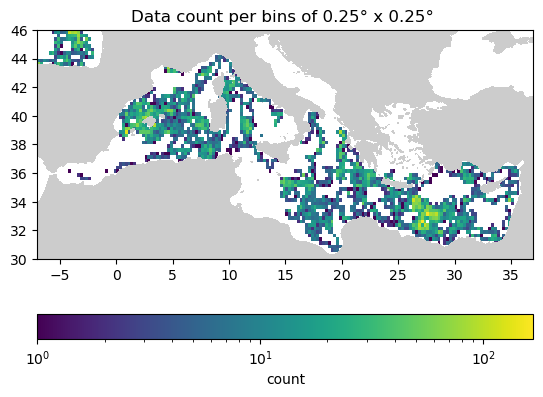

In [34]:
plt.hist2d(lon,lat,(lonr,latr),norm=matplotlib.colors.LogNorm())
colorbar(orientation="horizontal",label="count")
CoastalCurrents.Plotting.plotmap(bathname)
title("Data count per bins of $(step(lonr))° x $(step(latr))° ");

In [12]:
mask,(pm,pn),(xi,yi) = DIVAnd.domain(bathname,bathisglobal,lonr,latr)
hx, hy, h = DIVAnd.load_bath(bathname, bathisglobal, lonr, latr);

In [13]:
label = DIVAnd.floodfill(mask)
mask = label .== 1;

pcolormesh(xi,yi,mask)

In [14]:
len = 50e3

50000.0

In [21]:
robs = vcat(u,v)
robs = Float64.(nomissing(robs,NaN))
directionobs = vcat(fill(90,size(u)), fill(0,size(v)))
epsilon2 = 0.1
residual = zeros(size(robs))
g = 9.81;
g = 0;
x = [lon; lon]
y = [lat; lat]
eps2_boundary_constraint = -1
eps2_div_constraint = -1
#eps2_boundary_constraint = 1e-9
eps2_div_constraint = 1e+1
#figure()
uri,vri,ηi = DIVAndrun_HFRadar(
    mask,h,(pm,pn),(xi,yi),(x,y),robs,directionobs,len,epsilon2;
    eps2_boundary_constraint = eps2_boundary_constraint,
    eps2_div_constraint = eps2_div_constraint,
    # eps2_Coriolis_constraint = -1,
    # f = 0.001,
    # residual = residual,
    # g = g,
    # ratio = 100,
    # lenη = (000.0, 000.0, 24 * 60 * 60. * 10),
    # maxit = 100000,
    # tol = 1e-6,
);

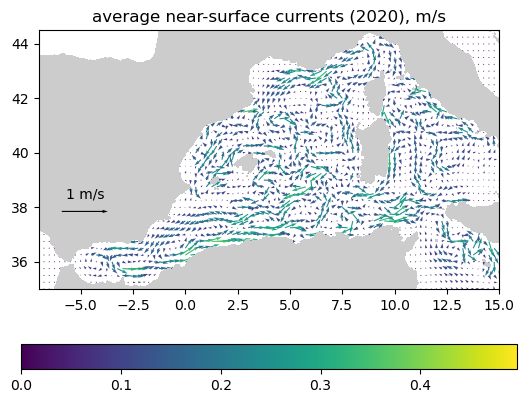

In [29]:
speedi = @. sqrt(uri^2 + vri^2)
clf(); q=quiver(xi,yi,uri,vri,speedi,scale=10)
quiverkey(q,0.1,0.3,1,"1 m/s")
xlim(-7,15)
ylim(35.,44.5)
#colorbar(orientation="vertical")
colorbar(orientation="horizontal")
title("average near-surface currents (2020), m/s")
#CoastalCurrents.Plotting.set_aspect_ratio()
#OceanPlot.plot_coastline()
CoastalCurrents.Plotting.plotmap(bathname)
#savefig(expanduser("~/Figures/bluecloud-drifter-vel-div-$(eps2_div_constraint).png"))